# Evaluation of CosmoFlow training

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/benchmarks/cosmoflow-benchmark/notebooks'

In [2]:
import os
import sys
import yaml
import pickle

sys.path.append('..')

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt

In [4]:
from models import get_model
from data.cosmo import construct_dataset
from utils.optimizers import get_optimizer

In [5]:
%matplotlib inline

In [6]:
plt.rcParams.update({'font.size': 14})

## Load the results

In [7]:
def load_config(result_dir):
    config_file = os.path.join(result_dir, 'config.pkl')
    with open(config_file, 'rb') as f:
        return pickle.load(f)

def load_history(result_dir):
    history_file = os.path.join(result_dir, 'history.csv')
    return pd.read_csv(history_file)

In [8]:
#result_dir = os.path.expandvars(config['output_dir'])
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-resnet-000'
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-v2-2020-02-27'
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-v2-hpo-478263-0'
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-v2-hpo-478268-0'
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-v2-hpo-478283-0'

# These have some kind of errors seemingly related to checkpoint resuming
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-2020-03-05'
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/alt-cosmoflow-2020-03-05'

# Running 4-node with data-staging
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-2020-03-08'
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-2020-03-09'
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-2020-03-11'
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-2020-03-11-2'
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-2020-03-11-3'
result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-2020-03-12'

In [9]:
ls -l $result_dir

total 2804308
-rw-rw---- 1 sfarrell sfarrell 44863784 Mar 13 00:07 checkpoint-001.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Mar 13 00:11 checkpoint-002.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Mar 13 00:15 checkpoint-003.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Mar 13 00:18 checkpoint-004.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Mar 13 00:22 checkpoint-005.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Mar 13 00:26 checkpoint-006.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Mar 13 00:29 checkpoint-007.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Mar 13 00:33 checkpoint-008.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Mar 13 00:37 checkpoint-009.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Mar 13 00:40 checkpoint-010.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Mar 13 00:44 checkpoint-011.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Mar 13 00:48 checkpoint-012.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Mar 13 00:52 checkpoint-013.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Mar 13 00:56 checkpoint

In [10]:
config = load_config(result_dir)
train_history = load_history(result_dir)

In [11]:
config

{'output_dir': '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-2020-03-12',
 'data': {'name': 'cosmo',
  'data_dir': '/tmp/sfarrell/cosmoflow-benchmark/data/cosmoUniverse_2019_05_4parE_tf',
  'n_train': 131072,
  'n_valid': 32768,
  'sample_shape': [128, 128, 128, 4],
  'batch_size': 4,
  'n_epochs': 64,
  'shard': True,
  'apply_log': True,
  'prefetch': 8,
  'staged_files': True},
 'model': {'name': 'cosmoflow',
  'input_shape': [128, 128, 128, 4],
  'target_size': 4,
  'conv_size': 32,
  'fc1_size': 128,
  'fc2_size': 64,
  'hidden_activation': 'LeakyReLU',
  'pooling_type': 'MaxPool3D',
  'dropout': 0.5},
 'optimizer': {'name': 'SGD',
  'lr': 0.01,
  'momentum': 0.9,
  'lr_scaling': 'none'},
 'train': {'loss': 'mse',
  'metrics': ['mae'],
  'lr_schedule': {16: 0.3, 32: 0.333},
  'early_stopping_patience': 8},
 'n_ranks': 32}

## View training history

In [12]:
train_history

,epoch,loss,lr,mean_absolute_error,time,val_loss,val_mean_absolute_error
0,0,0.210774,0.010000,0.373172,291.050537,0.164680,0.320823
1,1,0.169372,0.010000,0.329562,221.535578,0.133643,0.288175
2,2,0.148937,0.010000,0.308066,223.360908,0.108994,0.260539
3,3,0.127514,0.010000,0.284047,222.807022,0.076826,0.216519
4,4,0.105625,0.010000,0.257237,220.708042,0.071538,0.204932
...,...,...,...,...,...,...,...
59,59,0.032913,0.000999,0.141916,237.371262,0.046486,0.151159
60,60,0.032728,0.000999,0.141486,236.802672,0.046291,0.150838
61,61,0.032778,0.000999,0.141592,231.446476,0.046605,0.151621
62,62,0.032543,0.000999,0.141066,228.835835,0.046490,0.151999


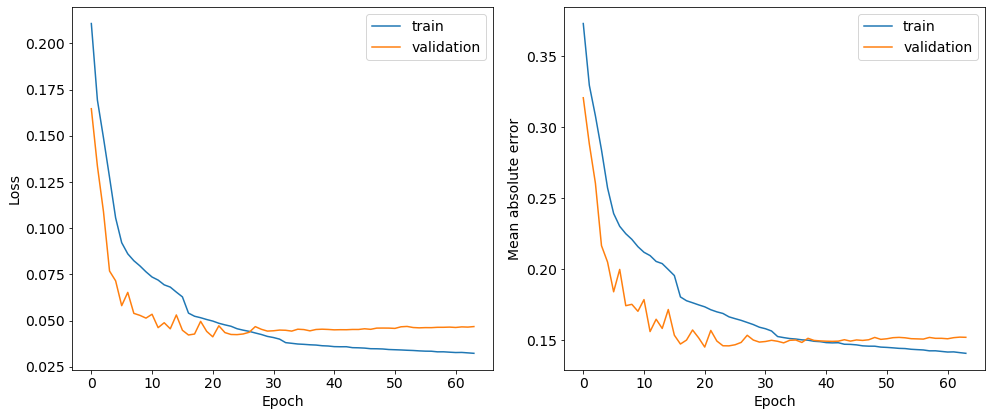

In [13]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 6))

ax0.plot(train_history.loss, label='train')
ax0.plot(train_history.val_loss, label='validation')
ax0.set_xlabel('Epoch')
ax0.set_ylabel('Loss')
ax0.legend(loc=0)

ax1.plot(train_history.mean_absolute_error, label='train')
ax1.plot(train_history.val_mean_absolute_error, label='validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean absolute error')
ax1.legend(loc=0)

plt.tight_layout()

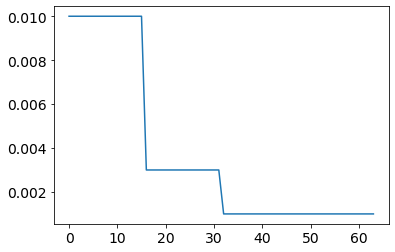

In [14]:
# Plot the learning rate
plt.figure()
plt.plot(train_history.lr)

In [15]:
# Choose best epoch based on validation loss
best_epoch = train_history.epoch.loc[train_history.val_loss.idxmin()]
print('Best epoch:', best_epoch)

Best epoch: 20


In [31]:
train_history.loc[best_epoch]

epoch                       20.000000
loss                         0.049750
lr                           0.003000
mean_absolute_error          0.173382
time                       236.616120
val_loss                     0.041232
val_mean_absolute_error      0.144995
Name: 20, dtype: float64

## Reload the model

In [16]:
import models.cosmoflow

# Load the model checkpoint
checkpoint = os.path.join(result_dir, 'checkpoint-{epoch:03d}.h5'.format(epoch=best_epoch+1))
model = tf.keras.models.load_model(checkpoint)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 128, 128, 128, 32) 1056      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 128, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 64, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 64, 64, 64)    16448     
_________________________________________________________________
lea

## Evaluate the model on a test set

In [17]:
def convert_data_to_np(dataset, n_steps):
    iter_next = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as sess:
        converted_data = [sess.run(iter_next) for i in range(n_steps)]
        return map(np.concatenate, zip(*converted_data))

def convert_labels_to_np(dataset, n_steps):
    iter_next = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as sess:
        return np.concatenate([sess.run(iter_next)[1] for i in range(n_steps)])

In [22]:
n_test_files = 1024
data_config = config['data']
batch_size = 4 #data_config['batch_size']

# data_dir in this config is using the staged path
#data_dir = data_config['data_dir']
data_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/data/cosmoUniverse_2019_05_4parE_tf_1'

samples_per_file = data_config.get('samples_per_file', 1)
n_test = n_test_files * samples_per_file
n_test_steps = n_test // batch_size

In [23]:
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)
             if f.endswith('tfrecord')]
test_files = all_files[-n_test_files:]

In [24]:
# Construct the test dataset
test_data = construct_dataset(test_files, batch_size=batch_size, n_epochs=1,
                              sample_shape=[128, 128, 128, 4],
                              apply_log=data_config.get('apply_log', False))

In [25]:
# Apply the model to the test set
test_pred = model.predict(test_data, steps=n_test_steps, verbose=1)

256/256 [==============================] - 149s 584ms/step


In [26]:
test_y = convert_labels_to_np(test_data, n_test_steps)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


## Model analysis

Let's make some detailed plots to understand the performance of the model

In [27]:
# Small sample of the test set for plotting input data distributions
n_sample_steps = 2
sample_x, sample_y = convert_data_to_np(test_data, n_sample_steps)

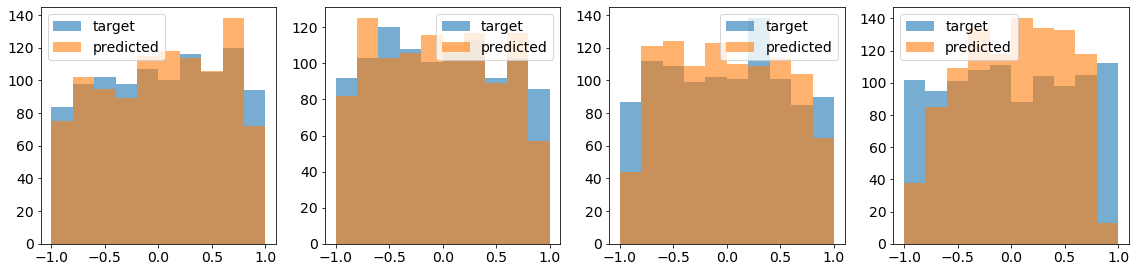

In [28]:
# 1D Distributions of cosmo params
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(16, 4))

hist_args = dict(bins=10, range=(-1,1), alpha=0.6)
ax0.hist(test_y[:,0], label='target', **hist_args)
ax0.hist(test_pred[:,0], label='predicted', **hist_args)
ax0.legend(loc=0)
ax1.hist(test_y[:,1], label='target', **hist_args)
ax1.hist(test_pred[:,1], label='predicted', **hist_args)
ax1.legend(loc=0)
ax2.hist(test_y[:,2], label='target', **hist_args)
ax2.hist(test_pred[:,2], label='predicted', **hist_args)
ax2.legend(loc=0)
ax3.hist(test_y[:,3], label='target', **hist_args)
ax3.hist(test_pred[:,3], label='predicted', **hist_args)
ax3.legend(loc=0)
plt.tight_layout()

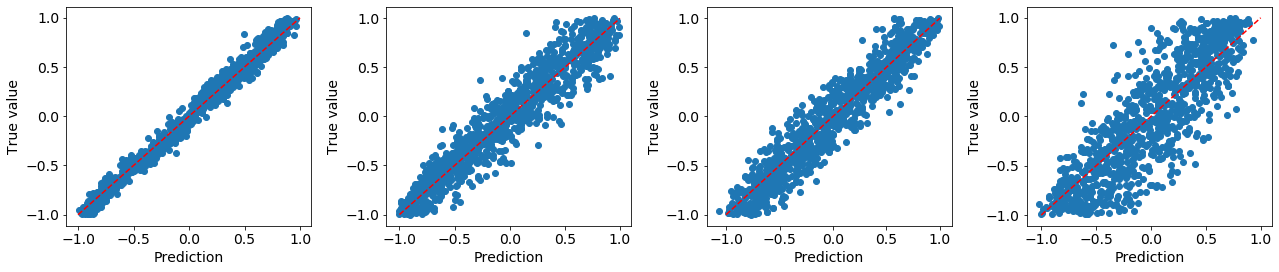

In [29]:
fig, axs = plt.subplots(ncols=4, figsize=(18, 4))

for i, ax in enumerate(axs):
    ax.scatter(test_pred[:,i], test_y[:,i])
    ax.plot([-1, 1], [-1, 1], 'r--')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True value')

plt.tight_layout()

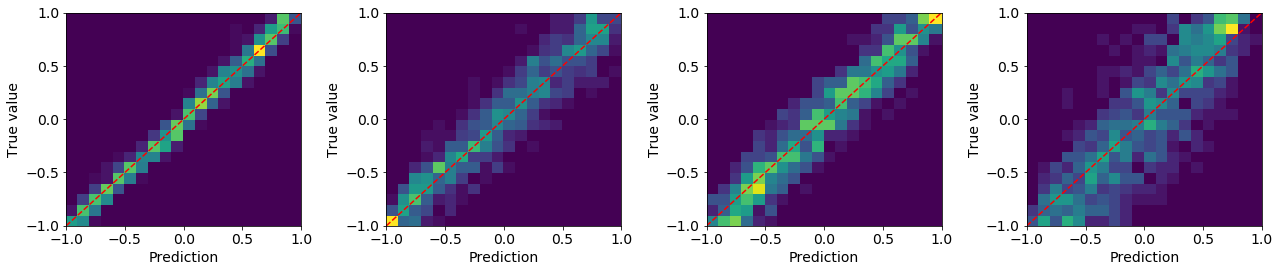

In [30]:
fig, axs = plt.subplots(ncols=4, figsize=(18, 4))

for i, ax in enumerate(axs):
    ax.hist2d(test_pred[:,i], test_y[:,i], bins=20, range=[[-1,1],[-1,1]])
    ax.plot([-1, 1], [-1, 1], 'r--')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True value')

plt.tight_layout()

## Discussion

This model is performing better in some parameters than others, but it is certainly converging.